# DEA Coastlines: GA ARD and USGS ARD comparison

In [3]:
import datacube
import matplotlib.pyplot as plt
from datacube.storage.masking import mask_invalid_data

import sys
sys.path.insert(1, '../../Tools/')
from dea_tools.spatial import subpixel_contours
from dea_tools.coastal import tidal_tag
from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import mostcommon_crs

create_local_dask_cluster()

/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


Client Scheduler: tcp://127.0.0.1:33929 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 16 Memory: 47.42 GB


In [4]:
# # Perth
# ymax, xmin = -31.529526, 115.600715
# ymin, xmax = -32.679979, 115.8
# out_name = 'perth'

# # Sydney
# ymax, xmin = -33.319639, 151.054712
# ymin, xmax = -34.115796, 151.436486
# out_name = 'sydney'

# # Gold Coast
# ymax, xmin = -27.815336, 153.363920
# ymin, xmax = -28.376845, 153.615233
# out_name = 'goldcoast'

# # Tasmania
# ymax, xmin = -42.77759, 146.8
# ymin, xmax = -43.69763, 147.66994
# out_name = 'tasmania'

# Victoria
ymax, xmin = -38.57161, 142.81714
ymin, xmax = -38.79799, 143.39996
out_name = 'victoria'

In [5]:
query = {
  'time': ('2013', '2021'),
  'lat': (ymin, ymax),
  'lon': (xmin, xmax),
  'align': (15, 15),
  'resolution': (-30, 30),
  'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000},
  'group_by': 'solar_day',
  'resampling': {'oa_fmask': 'nearest', '*': 'cubic'}
}

## Load USGS

In [6]:
usgs_dc = datacube.Datacube(config='/g/data/up71/projects/ARD_board_paper_Data/access_examples/ard_interoperability.conf')

In [7]:
usgs_crs = mostcommon_crs(usgs_dc,
                          product='usgs_ls8c_level2_2',
                          query=dict(time=('2013', '2021'),
                                     lat=(ymin, ymax),
                                     lon=(xmin, xmax)))

In [8]:
usgs_ds = usgs_dc.load(product='usgs_ls8c_level2_2',
                       output_crs=usgs_crs,
                       **query)

# Mask invalid data 
usgs_ds = mask_invalid_data(usgs_ds) 

# Rescale
usgs_sr_bands = [
    'coastal_aerosol', 'blue', 'green', 'lwir', 'nir', 'red', 'swir_1', 'swir_2'
]
usgs_ds.update(2.75e-5 * usgs_ds[usgs_sr_bands] - 0.2)

,Array,Chunk
Bytes,2.14 GB,12.00 MB
Shape,"(178, 877, 1710)","(1, 877, 1710)"
Count,1246 Tasks,178 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,2.14 GB,12.00 MB
Shape,"(178, 877, 1710)","(1, 877, 1710)"
Count,1246 Tasks,178 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


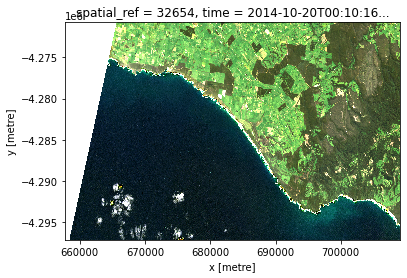

In [9]:
usgs_ds[['red', 'green', 'blue']].isel(time=30).to_array().plot.imshow(robust=True)

## Load GA

In [10]:
ga_dc = datacube.Datacube()

In [11]:
ga_ds = ga_dc.load(product='ga_ls8c_ard_3',
                   output_crs=usgs_crs,
                   measurements=[
                       'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir',
                       'nbart_swir_1', 'nbart_swir_2', 'oa_fmask'
                   ],
                   **query)

# Mask invalid data
ga_ds = mask_invalid_data(ga_ds)

# Rescale
ga_sr_bands = [
    'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1',
    'nbart_swir_2'
]
ga_ds.update(ga_ds[ga_sr_bands] / 10000.0)

,Array,Chunk
Bytes,4.50 GB,12.00 MB
Shape,"(375, 877, 1710)","(1, 877, 1710)"
Count,2250 Tasks,375 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,4.50 GB,12.00 MB
Shape,"(375, 877, 1710)","(1, 877, 1710)"
Count,2250 Tasks,375 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [12]:
# ga_ds[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=0).to_array().plot.imshow(robust=True)

## Select overlapping data

In [13]:
# Keep timesteps in both datasets
ga_ds = ga_ds.reindex(time=usgs_ds.time, tolerance='1D', method='nearest')

In [14]:
# Mask out invalid pixels from USGS for consistency (i.e. include same valid area in both)
ga_ds = ga_ds.where(~usgs_ds.red.isnull())

In [15]:
# time=0

# fig, axes = plt.subplots(1, 2)
# ga_ds[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=time).to_array().plot.imshow(ax=axes[0], robust=True)
# usgs_ds[['red', 'green', 'blue']].isel(time=time).to_array().plot.imshow(ax=axes[1], robust=True)

## Compute water index

In [16]:
# Compute MNDWI
ga_ds['mndwi'] = (ga_ds.nbart_green - ga_ds.nbart_swir_1) / (ga_ds.nbart_green + ga_ds.nbart_swir_1)
usgs_ds['mndwi'] = (usgs_ds.green - usgs_ds.swir_1) / (usgs_ds.green + usgs_ds.swir_1)

# Extract just MNDWI band and use GA fmask for both
cloud_mask = ga_ds.oa_fmask.isin([1, 4, 5])
ga_mndwi = ga_ds.mndwi.where(cloud_mask)
usgs_mndwi = usgs_ds.mndwi.where(cloud_mask)

In [17]:
# time=0

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# ga_mndwi.isel(time=time).plot.imshow(ax=axes[0], vmin=-0.5, vmax=0.5, cmap='RdBu')
# usgs_mndwi.isel(time=time).plot.imshow(ax=axes[1], vmin=-0.5, vmax=0.5, cmap='RdBu')

## Tidally constrain and load into memory

In [18]:
# Tag imagery with tide heights
tidal_tag(ga_mndwi)
tidal_tag(usgs_mndwi)

# Calculate tide thresholds
tide_offset = (usgs_mndwi.tide_height.max() - usgs_mndwi.tide_height.min()) * 0.25
tide_min = 0 - tide_offset
tide_max = 0 + tide_offset

# Restrict to mid-tide
usgs_mndwi_tides = usgs_mndwi.sel(time = (usgs_mndwi.tide_height > tide_min) & 
                                         (usgs_mndwi.tide_height < tide_max))
ga_mndwi_tides = ga_mndwi.sel(time = (ga_mndwi.tide_height > tide_min) & 
                                     (ga_mndwi.tide_height < tide_max))

# Load into memory
print('Loading USGS data')
usgs_mndwi_tides.load()
print('Loading GA data')
ga_mndwi_tides.load()

Setting tide modelling location from dataset centroid: 143.11, -38.69
Setting tide modelling location from dataset centroid: 143.11, -38.69
Loading USGS data
Loading GA data


<xarray.DataArray 'mndwi' (time: 126, y: 877, x: 1710)>
array([[[        nan,         nan,         nan, ..., -0.60720629,
         -0.59685996, -0.59275284],
        [        nan,         nan,         nan, ..., -0.60083377,
         -0.60529666, -0.60445531],
        [        nan,         nan,         nan, ..., -0.60521932,
         -0.61442588, -0.60524846],
        ...,
        [ 0.69354839,  0.6744186 ,  0.75862069, ...,  0.67213115,
          0.69369369,  0.71681416],
        [ 0.68      ,  0.65289256,  0.65811966, ...,  0.73913043,
          0.65811966,  0.6779661 ],
        [ 0.68253968,  0.66666667,  0.74137931, ...,  0.70247934,
          0.70434783,  0.72413793]],

       [[        nan,         nan,         nan, ..., -0.55774278,
         -0.55840648, -0.56997545],
        [        nan,         nan,         nan, ..., -0.55895197,
         -0.57284404, -0.54892688],
        [        nan,         nan,         nan, ..., -0.5477551 ,
         -0.56542617, -0.56378915],
...
        [        nan,         nan,         nan, ...,  0.85046729,
          0.86451613,  0.85350318],
        [        nan,         nan,         nan, ...,         nan,
                 nan,  0.82926829],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2013-03-26T00:11:16.445390 ... 2021-05...
  * y            (y) float64 -4.271e+06 -4.271e+06 ... -4.297e+06 -4.297e+06
  * x            (x) float64 6.578e+05 6.578e+05 ... 7.090e+05 7.091e+05
    spatial_ref  int32 32654
    tide_height  (time) float64 0.075 0.027 -0.127 ... 0.016 -0.062 -0.186

In [19]:
# Resample to annual composites
freq='1Y'
ga_mndwi_resamp = ga_mndwi_tides.resample(time=freq).median()
usgs_mndwi_resamp = usgs_mndwi_tides.resample(time=freq).median()

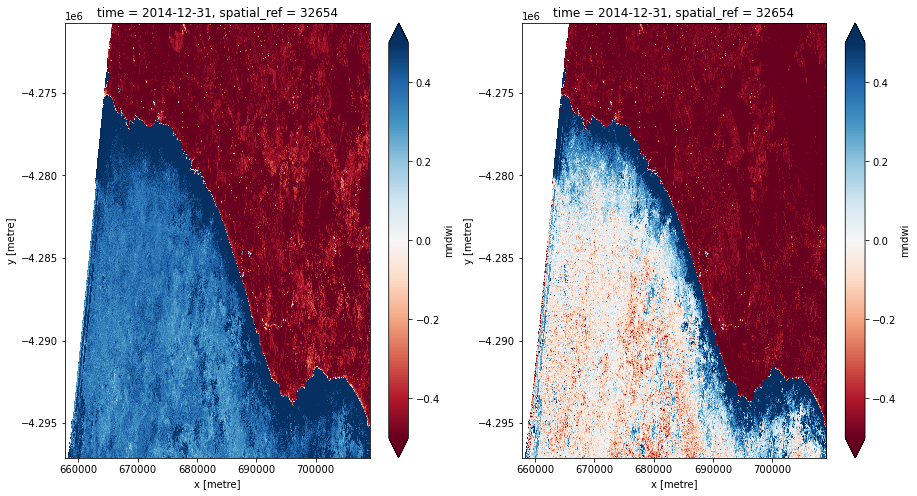

In [20]:
# time=1
# fig, axes = plt.subplots(1, 2, figsize=(15, 8))
# ga_mndwi_resamp.isel(time=time).plot.imshow(ax=axes[0], vmin=-0.5, vmax=0.5, cmap='RdBu')
# usgs_mndwi_resamp.isel(time=time).plot.imshow(ax=axes[1], vmin=-0.5, vmax=0.5, cmap='RdBu')

#### Extract subpixel shorelines

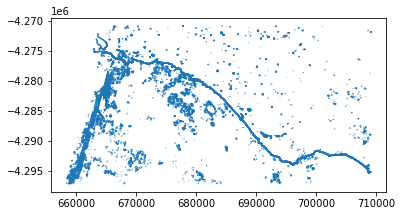

In [21]:
# Extract contours
ga_gdf = subpixel_contours(da=ga_mndwi_resamp,
                                 z_values=[0],
                                 crs=ga_ds.crs,
                                output_path=f'ga_coastlines_{out_name}.geojson')
ga_gdf.plot()

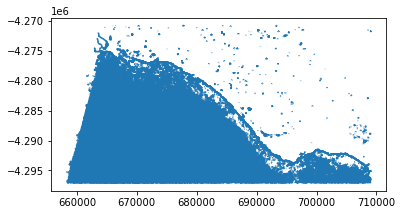

In [22]:
# Extract contours
usgs_gdf = subpixel_contours(da=usgs_mndwi_resamp,
                                 z_values=[0],
                                 crs=usgs_ds.crs,
                                output_path=f'usgs_coastlines_{out_name}.geojson')
usgs_gdf.plot()